# Grad-CAM Visualization for Our Combined Models

This notebook shows **step by step** how to apply **Grad-CAM (Gradient-weighted Class Activation Mapping)**  
to visualize which regions of an image our models (ConvNeXt & MobileNet) focus on when making predictions.

> Grad-CAM helps us understand *why* a model predicts a certain class by highlighting important image regions.


## 1. Setup and Imports

We’ll import all the basic libraries:  
- `torch` and `torchvision` for the PyTorch ConvNeXt model  
- `tensorflow` and `keras` for the MobileNet model  
- Common tools like `numpy`, `matplotlib`, and `PIL` for handling images


In [3]:
# basic imports
import os, json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# torch + tf
import torch
import torch.nn as nn
from torchvision import models, transforms

import tensorflow as tf
from tensorflow.keras.models import load_model

## 2. Device and Image Preprocessing

We set up our device (`CPU` or `GPU`) and define helper functions to **load**, **resize**, and **normalize** images so both models can use them.

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

def load_and_resize(path, size=224):
    img = Image.open(path).convert("RGB")
    return img.resize((size, size))

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

pt_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

def preprocess_for_convnext(pil_img):
    x = pt_transform(pil_img)
    return x.unsqueeze(0).to(device)

def preprocess_for_mobilenet(pil_img):
    arr = np.array(pil_img).astype("float32") / 255.0
    return np.expand_dims(arr, axis=0)


Using device: cpu


## Quick Test

In [30]:
img = load_and_resize("example.png")
x_convnext = preprocess_for_convnext(img)
x_mobilenet = preprocess_for_mobilenet(img)

print("ConvNeXt input shape:", x_convnext.shape)
print("MobileNet input shape:", x_mobilenet.shape)


ConvNeXt input shape: torch.Size([1, 3, 224, 224])
MobileNet input shape: (1, 224, 224, 3)


## 3. Load ConvNeXt (PyTorch) and MobileNet (Keras)

We load our trained weights:
- `Checkpoints/convnext.pt` → ConvNeXt (2 classes)
- `Checkpoints/mobilenet.keras` → MobileNet (binary)

In [31]:
#ConvNeXt (PyTorch)
CONVNEXT_CKPT_PATH = "Checkpoints/convnext.pt"
convnext_cls = models.convnext_tiny(weights=None)

if os.path.exists(CONVNEXT_CKPT_PATH):
    print("Found checkpoint at:", CONVNEXT_CKPT_PATH)
    # load checkpoint into the 1000-class model (no shape mismatch)
    state = torch.load(CONVNEXT_CKPT_PATH, map_location="cpu")
    convnext_cls.load_state_dict(state)
    print("Pretrained weights loaded")

    # now replace the head with a 2-class classifier
    in_features = convnext_cls.classifier[2].in_features
    convnext_cls.classifier[2] = nn.Linear(in_features, 2)

    convnext_cls = convnext_cls.to(device).eval()
    print("ConvNeXt now has 2 output classes")
else:
    raise FileNotFoundError("ConvNeXt checkpoint not found at Checkpoints/convnext.pt")

#MobileNet (Keras)
MOBILENET_KERAS = "Checkpoints/mobilenet.keras"
mobilenet_keras = load_model(MOBILENET_KERAS)
print("MobileNet loaded")

Found checkpoint at: Checkpoints/convnext.pt
Pretrained weights loaded
ConvNeXt now has 2 output classes
MobileNet loaded


## 4. Load one test image and preprocess it

In [32]:
from PIL import Image

IMAGE_PATH = "example.png"  

# load & resize to 224x224
img = Image.open(IMAGE_PATH).convert("RGB").resize((224, 224))

# apply your existing preprocessors
x_convnext = preprocess_for_convnext(img)     # (1,3,224,224) torch tensor
x_mobilenet = preprocess_for_mobilenet(img)   # (1,224,224,3) numpy array

print("preprocessed:", x_convnext.shape, x_mobilenet.shape)

preprocessed: torch.Size([1, 3, 224, 224]) (1, 224, 224, 3)


## 5.  Grad-CAM for ConvNeXt (PyTorch)

**What we want:** a heatmap that shows *where* ConvNeXt looked to make its prediction.

**How Grad-CAM works (simple):**
1. Do a **forward pass** → get the model’s scores (logits).
2. Pick the **target class** (we’ll use the **predicted** class).
3. Do a **backward pass** to get **gradients** of that class with respect to the **last conv feature maps**.
4. **Average** those gradients over height/width → this gives one **weight per channel**.
5. Take a **weighted sum** of the feature maps → this is the **CAM** (class activation map).
6. Apply **ReLU** (no negatives), **normalize** to 0..1, **resize**, and **overlay** on the original image.


C:\Users\emily\AppData\Local\Temp\ipykernel_16800\3811748241.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heat_rgba = cm.get_cmap("jet")(cam_arr)              # (H, W, 4)


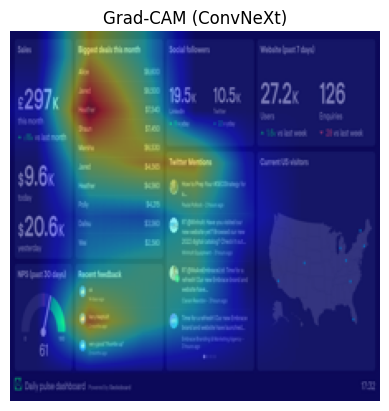

In [33]:
import torch.nn.functional as F

# TARGET LAYER
target_layer = convnext_cls.features[-1][-1]

# GRAD-CAM
def gradcam_convnext(model, x, target_layer, class_idx=None):
    model.zero_grad(set_to_none=True)

    feats = {}
    grads = {}

    def fwd_hook(_m, _in, out):
        feats["A"] = out                       # (N, C, h, w)
        out.register_hook(lambda g: grads.setdefault("dA", g))  # (N, C, h, w)

    handle = target_layer.register_forward_hook(fwd_hook)


    logits = model(x)                          # (1, 2)
    if class_idx is None:
        class_idx = int(logits.argmax(dim=1))  # explain the predicted class
    score = logits[0, class_idx]

    score.backward()

    A  = feats["A"]            # (1, C, h, w)
    dA = grads["dA"]           # (1, C, h, w)
    w  = dA.mean(dim=(2, 3), keepdim=True)  # channel weights (1, C, 1, 1)

    cam = (w * A).sum(dim=1)   # (1, h, w)
    cam = F.relu(cam)

    cam -= cam.min()
    cam /= (cam.max() + 1e-8)

    handle.remove()
    return cam[0].detach().cpu().numpy()  # (h, w) in [0,1]

#RESIZE + OVERLAY
def overlay_cam_on_image(pil_img, cam_01, alpha=0.45):
    W, H = pil_img.size
    cam_img = Image.fromarray((cam_01 * 255).astype(np.uint8)).resize((W, H), Image.BILINEAR)
    cam_arr = np.asarray(cam_img).astype(np.float32) / 255.0

    heat_rgba = cm.get_cmap("jet")(cam_arr)              # (H, W, 4)
    heat = Image.fromarray((heat_rgba * 255).astype(np.uint8), mode="RGBA")

    base = pil_img.convert("RGBA")
    return Image.blend(base, heat, alpha).convert("RGB")

cam = gradcam_convnext(convnext_cls, x_convnext, target_layer)  # (h, w)
overlay = overlay_cam_on_image(img, cam, alpha=0.45)

plt.imshow(overlay); plt.axis("off"); plt.title("Grad-CAM (ConvNeXt)")
plt.show()

## 5.1 ConvNeXt Prediction

We first obtain the class probabilities from the ConvNeXt model using a forward pass.  
Softmax returns two values corresponding to:
- Index 0 → Not Compliant  
- Index 1 → Compliant  

These probabilities will determine which class the Grad-CAM visualizes.

In [45]:
# ConvNeXt prediction
with torch.no_grad():
    logits = convnext_cls(x_convnext)
    probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

print("ConvNeXt prediction:")
print(f"Compliant probability: {probs[0]:.2%}")
print(f"Not Compliant probability: {probs[1]:.2%}")

ConvNeXt prediction:
Compliant probability: 67.34%
Not Compliant probability: 32.66%


## 6. Grad-CAM for MobileNet (Keras)

We do the same steps for MobileNet:
1) pick the last Conv2D layer
2) compute gradients for the predicted class
3) build a 0..1 heatmap and overlay

In [ ]:
# First, let's see what layers the model has
print("Model layers:")
for i, layer in enumerate(mobilenet_keras.layers):
    print(f"{i}: {layer.name} - {layer.__class__.__name__}")

Model layers:
0: mobilenetv2_1.00_224 - Functional
1: global_average_pooling2d - GlobalAveragePooling2D
2: dense - Dense


Using layer: Conv_1


C:\Users\emily\AppData\Local\Temp\ipykernel_16800\4127818813.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgba = cm.get_cmap("jet")(heat_arr)


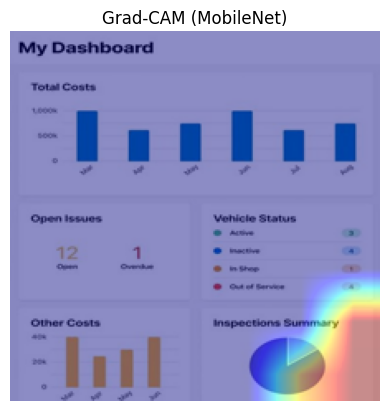

In [57]:
# GRAD-CAM FOR MOBILENET (Keras/TensorFlow)
import tensorflow as tf
from tensorflow.keras import Model

def gradcam_mobilenet(model, img_array, layer_name=None):
    """
    Grad-CAM for Keras/TensorFlow MobileNet model
    """
    # Get the MobileNet base
    mobilenet_base = model.layers[0]
    
    # Find last convolutional layer
    if layer_name is None:
        for layer in reversed(mobilenet_base.layers):
            if 'Conv' in layer.__class__.__name__:
                layer_name = layer.name
                break
    
    print(f"Using layer: {layer_name}")
    
    # Build a model that outputs both the target conv layer and final predictions
    last_conv_layer = mobilenet_base.get_layer(layer_name)
    
    # Create a new model from input to the last conv layer output
    last_conv_layer_model = Model(mobilenet_base.input, last_conv_layer.output)
    
    # Create classifier model from last conv to output
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    
    # Apply remaining layers (everything after the conv layer in base model)
    found_target = False
    for layer in mobilenet_base.layers:
        if found_target:
            x = layer(x)
        if layer.name == layer_name:
            found_target = True
    
    x = model.layers[1](x)  # GlobalAveragePooling2D
    x = model.layers[2](x)  # Dense
    
    classifier_model = Model(classifier_input, x)
    
    img_tensor = tf.cast(img_array, tf.float32)
    
    with tf.GradientTape() as tape:
        conv_outputs = last_conv_layer_model(img_tensor)
        tape.watch(conv_outputs)
        predictions = classifier_model(conv_outputs)
        
        if predictions.shape[-1] == 1:
            top_class_channel = predictions[:, 0]
        else:
            top_pred_index = tf.argmax(predictions[0])
            top_class_channel = predictions[:, top_pred_index]
    
    grads = tape.gradient(top_class_channel, conv_outputs)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    
    return heatmap.numpy()


cam_mobilenet = gradcam_mobilenet(mobilenet_keras, x_mobilenet)
overlay_mobilenet = overlay_cam_on_image(img, cam_mobilenet, alpha=0.45)

plt.imshow(overlay_mobilenet)
plt.axis("off")
plt.title("Grad-CAM (MobileNet)")
plt.show()

## 6.1 Model Predicition

After generating and visualizing the Grad-CAM heatmap, we also print the model’s actual
prediction for the input image. This helps confirm **which class the Grad-CAM visualization is explaining**.

In [ ]:
#Verify what the model is actually predicting
print("MobileNet prediction:")
prob = mobilenet_keras.predict(x_mobilenet, verbose=0)[0][0]
print(f"Not Compliant probability: {prob:.2%}")
print(f"Compliant probability: {1-prob:.2%}")

MobileNet prediction:
Not Compliant probability: 21.86%
Compliant probability: 78.14%


## 7. Grad-CAM on Multiple *Not Compliant* Images

To further evaluate how well MobileNet focuses on the correct regions, we randomly sample three images from the **Not Compliant** dataset and generate a Grad-CAM heatmap for each one.


Image: ./Scaling _dataset/Not Compliant\Scaling_not_compliant_015.jpg
Prediction: Not Compliant
Compliant probability:     29.99%
Not Compliant probability: 70.01%
Using layer: Conv_1


C:\Users\emily\AppData\Local\Temp\ipykernel_16800\4127818813.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgba = cm.get_cmap("jet")(heat_arr)


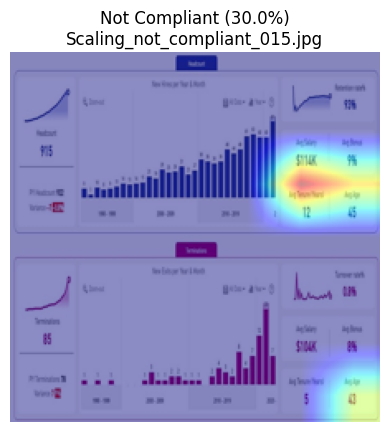


Image: ./Scaling _dataset/Not Compliant\Scaling_not_compliant_017.jpg
Prediction: Not Compliant
Compliant probability:     41.37%
Not Compliant probability: 58.63%
Using layer: Conv_1


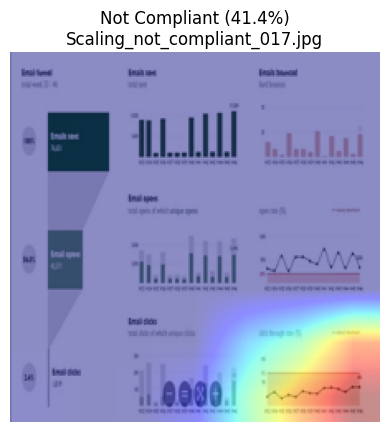


Image: ./Scaling _dataset/Not Compliant\Scaling_not_compliant_019.jpg
Prediction: Not Compliant
Compliant probability:     17.86%
Not Compliant probability: 82.14%
Using layer: Conv_1


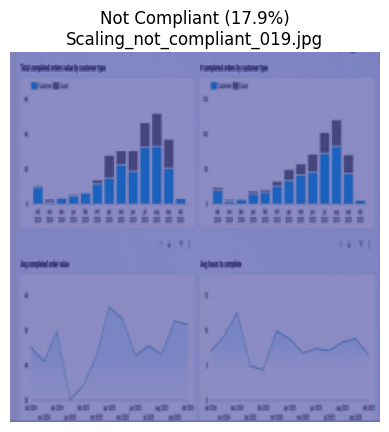

In [62]:
import os, random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

folder = "./Scaling _dataset/Not Compliant"
images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".jpg")]
sample_images = random.sample(images, 3)  # pick 3 random images

for path in sample_images:
    print(f"\nImage: {path}")

    # 1. Load + preprocess
    img = Image.open(path).convert("RGB").resize((224, 224))
    x_mobilenet = np.expand_dims(np.array(img).astype("float32") / 255.0, axis=0)

    # 2. Prediction
    prob_compliant = float(mobilenet_keras.predict(x_mobilenet, verbose=0)[0][0])
    label = "Compliant" if prob_compliant >= 0.5 else "Not Compliant"

    print(f"Prediction: {label}")
    print(f"Compliant probability:     {prob_compliant:.2%}")
    print(f"Not Compliant probability: {1 - prob_compliant:.2%}")

    # 3. Grad-CAM
    cam = gradcam_mobilenet(mobilenet_keras, x_mobilenet)

    # 4. Overlay
    overlay = overlay_cam_on_image(img, cam, alpha=0.45)

    # 5. Show result
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"{label} ({prob_compliant:.1%})\n{os.path.basename(path)}")
    plt.show()


## 8. Grad-CAM on Multiple *Compliant* Images

To confirm whether MobileNet is focusing on the correct regions for **Compliant** examples, we randomly select three images from the Compliant dataset. For each image, we:

This helps evaluate how consistently the model identifies regions that contribute to a *Compliant* classification.



Image: ./Scaling _dataset/Compliant\Scaling_compliant_018.jpg
Prediction: Compliant
Compliant probability: 93.84%
Not Compliant probability: 6.16%
Using layer: Conv_1


C:\Users\emily\AppData\Local\Temp\ipykernel_16800\4127818813.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgba = cm.get_cmap("jet")(heat_arr)


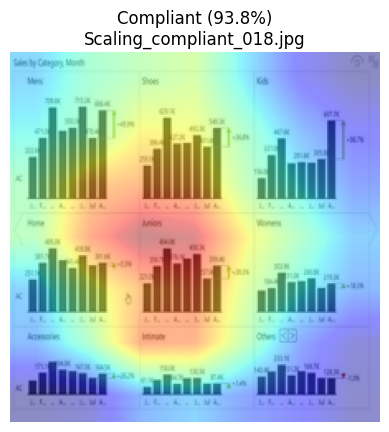


Image: ./Scaling _dataset/Compliant\Scaling_compliant_015.jpg
Prediction: Compliant
Compliant probability: 80.87%
Not Compliant probability: 19.13%
Using layer: Conv_1


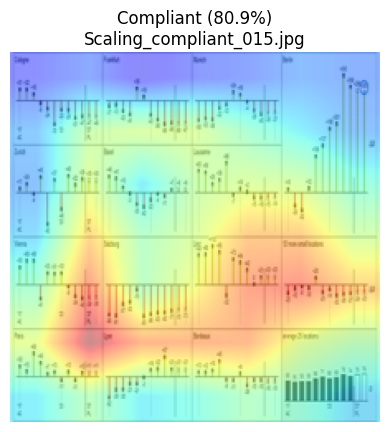


Image: ./Scaling _dataset/Compliant\Scaling_compliant_004.jpg
Prediction: Compliant
Compliant probability: 89.95%
Not Compliant probability: 10.05%
Using layer: Conv_1


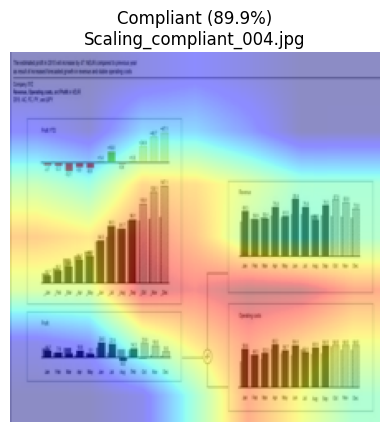

In [52]:
import os, random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

folder = "./Scaling _dataset/Compliant"  # or "./Scaling _dataset/Not Compliant"
images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".jpg")]
sample_images = random.sample(images, 3)  # choose 3 random ones

for path in sample_images:
    print(f"\nImage: {path}")

    # 1. Load and preprocess
    img = Image.open(path).convert("RGB").resize((224, 224))
    x_mobilenet = np.expand_dims(np.array(img).astype("float32") / 255.0, axis=0)

    # 2. Predict class (sigmoid → probability of Compliant)
    prob_compliant = float(mobilenet_keras.predict(x_mobilenet, verbose=0)[0][0])
    label = "Compliant" if prob_compliant >= 0.5 else "Not Compliant"

    print(f"Prediction: {label}")
    print(f"Compliant probability: {prob_compliant:.2%}")
    print(f"Not Compliant probability: {1 - prob_compliant:.2%}")

    # 3. Compute Grad-CAM
    cam = gradcam_mobilenet(mobilenet_keras, x_mobilenet)

    # 4. Overlay heatmap
    overlay = overlay_cam_on_image(img, cam, alpha=0.45)

    # 5. Show image
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"{label} ({prob_compliant:.1%})\n{os.path.basename(path)}")
    plt.show()


## 9. Side-by-Side Grad-CAM Comparison (ConvNeXt vs. MobileNet)

To better understand how each model interprets the same input image, we generate a side-by-side visualization comparing:

- **Original image**
- **ConvNeXt Grad-CAM heatmap**
- **MobileNetV2 Grad-CAM heatmap**

C:\Users\emily\AppData\Local\Temp\ipykernel_16800\4127818813.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgba = cm.get_cmap("jet")(heat_arr)


Using layer: Conv_1


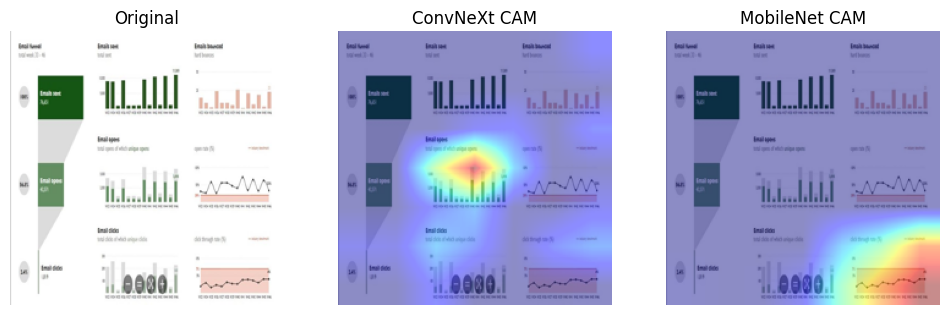

In [76]:
img_path = "./Scaling _dataset/Not Compliant/Scaling_not_compliant_017.jpg"

# Load image
img = Image.open(img_path).convert("RGB").resize((224, 224))

# ConvNeXt
x_cx = preprocess_for_convnext(img)
with torch.no_grad():
    logits_cx = convnext_cls(x_cx)
    probs_cx = torch.softmax(logits_cx, dim=1)[0].cpu().numpy()
pred_idx_cx = int(np.argmax(probs_cx))
cam_cx = gradcam_convnext(convnext_cls, x_cx, target_layer, class_idx=pred_idx_cx)
overlay_cx = overlay_cam_on_image(img, cam_cx, alpha=0.45)

# MobileNet
x_mbn = preprocess_for_mobilenet(img)
prob_compliant = float(mobilenet_keras.predict(x_mbn, verbose=0)[0][0])
label_mbn = "Compliant" if prob_compliant >= 0.5 else "Not Compliant"
cam_mbn = gradcam_mobilenet(mobilenet_keras, x_mbn)
overlay_mbn = overlay_cam_on_image(img, cam_mbn, alpha=0.45)

# Plot side by side
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img); plt.axis("off"); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(overlay_cx); plt.axis("off"); plt.title(f"ConvNeXt CAM")
plt.subplot(1,3,3); plt.imshow(overlay_mbn); plt.axis("off"); plt.title(f"MobileNet CAM")
plt.show()


## ✅ Grad-CAM Summary

In this notebook, Grad-CAM was used to visualize which regions of the image contribute most to the predictions of two models:

- **ConvNeXt (PyTorch)**
- **MobileNetV2 (Keras)**

For each model, we:
- Ran inference on example images from both classes (*Compliant* and *Not Compliant*).
- Generated Grad-CAM heatmaps for the predicted class.
- Overlaid the heatmaps on the original images.

### Observations

- In some cases, both models attend to background or non-scaling areas, which suggests that they may rely on additional visual cues beyond just the scaling region.
- The MobileNet a lot of the time does not even have a heatmap indication.

Overall, Grad-CAM helped us interpret the models' decisions and verify whether they use reasonable parts of the input images when making predictions.